In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [56]:
import sys
from collections import Counter, defaultdict
import json

Let analyse a tweet and get the hashtags involed in the tweet

In [57]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [58]:
def get_text(tag):
    return tag.get('text').lower()

In [59]:
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    hastags = Counter()
    for line in f:
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        hastags.update(hashtags_in_tweet)
    for tag,count in hastags.most_common(25):
        print("{} : {}".format(tag, count))

ebola : 10
kasai : 8
experts : 8
quota100 : 7
goma : 4
kivu : 4
ituri : 3
fardc : 3
kabila : 3
intelligence : 3
hautkatanga : 3
lubumbashi : 3
beni : 3
muyej : 3
spotlightoncongo : 2
food : 2
lumumba : 2
covertcapital : 2
visitzimbabwe : 2
rhino : 2
vacuna : 2
zimbabwe : 2
afrique : 2
abidjan : 2
kikoso : 1


let check how our people uses others hastags apart from the one I selected 

In [60]:
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    hashtag_count = defaultdict(int)
    for line in f :
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        n_of_hashtags = len(hashtags_in_tweet)
        hashtag_count[n_of_hashtags] +=1
        tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
        tweet_without_hashtags = hashtag_count[0]
        total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

243 tweets without hashtags  (72.53731343283582%)
92 tweets with at least one hashtag  (27.46268656716418%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [61]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [62]:
def process_text(text, tokenizer= TweetTokenizer(), stop_words=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in stop_words and not token.isdigit()]
    

let do the analysis now

In [63]:
tweet_tokenizer = TweetTokenizer()
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les']
stop_words= punctuation + stop_word_list_english + stop_word_list_french + others_words

In [64]:
term_counts = Counter()
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    for line in f:
        tweet = json.loads(line)
        tokens = process_text(text=tweet.get('text'), tokenizer=tweet_tokenizer, stop_words=stop_words)
        term_counts.update(tokens)
    for tag, count in term_counts.most_common(20):
        print("{}: {}".format(tag, count))

’: 118
#rdc: 108
rdc: 79
ilunga: 24
drc: 22
«: 19
ministre: 18
tshisekedi: 18
première: 18
»: 16
#drc: 15
congo: 15
président: 15
premier: 15
diamant: 14
quelli: 14
congolaise: 13
chutes: 12
femme: 12
fait: 12


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [47]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

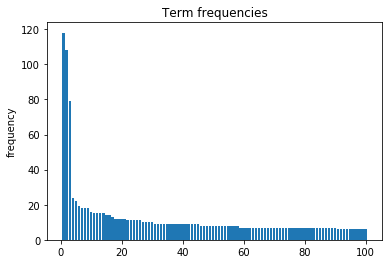

In [48]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [84]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [68]:
def open_file(path):
    """
    a utility gerator function which open a file an return a iterator of his content
    """
    with open(path, 'r') as f :
        for line in f:
            tweet = json.loads(line)
            yield tweet

In [73]:
all_dates = list()
for tweet in open_file('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl'):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [82]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

In [110]:
datemax

datetime.datetime(2015, 10, 31, 18, 0)

In [98]:
datemin = datetime(2015, 10, 31, 15, 0)
datemax = datetime(2015, 10, 31, 18, 0)

In [122]:
idx.max() - idx.min()

Timedelta('0 days 00:33:58')

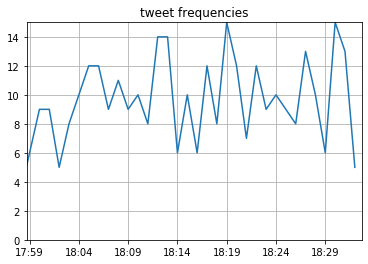

In [124]:
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=5)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [125]:
!pip install WordCloud

     |████████████████████████████████| 163kB 384kB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 2.0MB/s eta 0:00:01


In [139]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [137]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

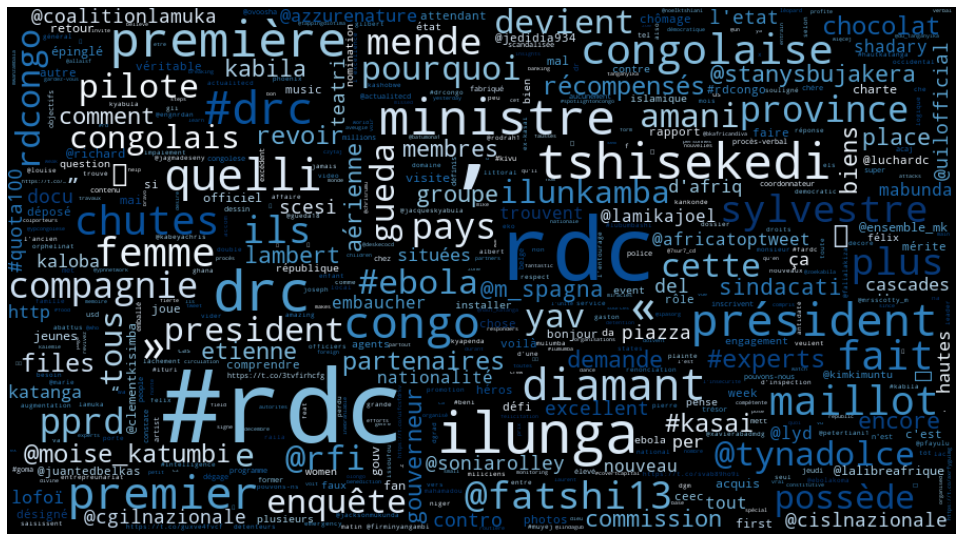

In [138]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

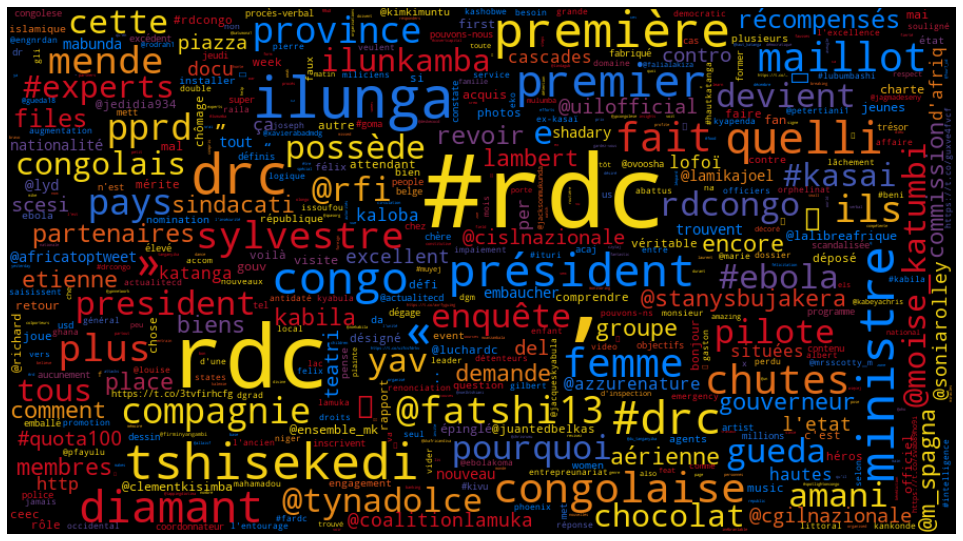

In [161]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()